# Pancreas Basics

This tutorial shows how to apply CellRank in order to infer root and final states of a developmental process and how to compute probabilistic fate mappings.  The first part of this tutorial is very similar to [scVelo's tutorial on pancreatic endocrinogenesis](https://scvelo-notebooks.readthedocs.io/Pancreas.html). The data we use here comes from [Bastidas-Ponce et al. (2018)](https://dev.biologists.org/content/146/12/dev173849.abstract). For more info on scVelo, see the [documentation](https://scvelo-notebooks.readthedocs.io/index.html) or read the [preprint](https://www.biorxiv.org/content/10.1101/820936v1). 

This is the 'basic' or **high level mode** to interact with cellrank, which is quick and simple but does not offer as many options as the lower level mode, in which you interact directly with our `Kernels` and `Estimators`. If you would like to get to know this more advanced way of interacting with CellRank, see the [pancreas advanced](https://cellrank-notebooks.readthedocs.io/en/latest/pancreas_advanced.html) tutorial.

This tutorial notebook can be downloaded using the following [link](https://github.com/theislab/cellrank_notebooks/raw/master/docs/source/pancreas_basic.ipynb).

## Import packages & data

Easiest way to start is to download [Miniconda3](https://docs.conda.io/en/latest/miniconda.html) along with the environment file found [here](https://raw.githubusercontent.com/theislab/cellrank_notebooks/master/environment.yml). To create the environment, run `conda create -f environment.yml`. Note that to keep the environment as minimal as possible, it doesn't include `rpy2`, which is required to run the last part of this notebook, the smoothed gene expression trends along individual trajectories.

In [1]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import matplotlib.cm as cm

scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo')
cr.settings.verbosity = 2

First, we need to get the data. The following commands will download the `adata` object and save it under `datasets/endocrinogenesis_day15.5.h5ad`.

In [2]:
adata = cr.datasets.pancreas()
scv.utils.show_proportions(adata)
adata

Abundance of ['spliced', 'unspliced']: [0.81 0.19]


AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'clusters_sizes', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_bbknn', 'X_umap_harmony'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

## Pre-process the data

Filter out genes which don't have enough spliced/unspliced counts, normalize and log transform the data and restrict to the top highly variable genes. Further, compute principal components and moments for velocity estimation. These are standard scanpy/scvelo functions, for more information about them, see the [scVelo API](https://scvelo.readthedocs.io/api.html).

In [3]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
sc.tl.pca(adata)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
Logarithmized X.
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


## Run scVelo

We will use the [dynamical model](https://scvelo.readthedocs.io/DynamicalModeling.html) from scVelo to estimate the velocities. The first step, estimating the parameters of the dynamical model,  may take a while (~10min). To make sure we only have to run this once, we developed a caching extension called [scachepy](https://github.com/theislab/scachepy). scachepy does not only work for `recover_dynamics`, but it can cache the output of almost any scanpy or scvelo function. To install it, simply run 

```
pip install git+https://github.com/theislab/scachepy
```

If you don't want to install scachepy now, don't worry, the below cell will run without it as well and this is the only place in this tutorial where we're using it. 

In [4]:
try:
    import scachepy
    c = scachepy.Cache('../../cached_files/basic_tutorial/')
    c.tl.recover_dynamics(adata, force=False)
except ModuleNotFoundError:
    print("You don't seem to have scachepy installed, but that's fine, you just have to be a bit patient (~10min). ")
    scv.tl.recover_dynamics(adata)

Loading data from: `recover_dynamics.pickle`.


Once we have the parameters, we can use these to compute the velocities and the velocity graph. The velocity graph is a weighted graph that specifies how likely two cells are to transition into another, given their velocity vectors and relative positions. 

In [5]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


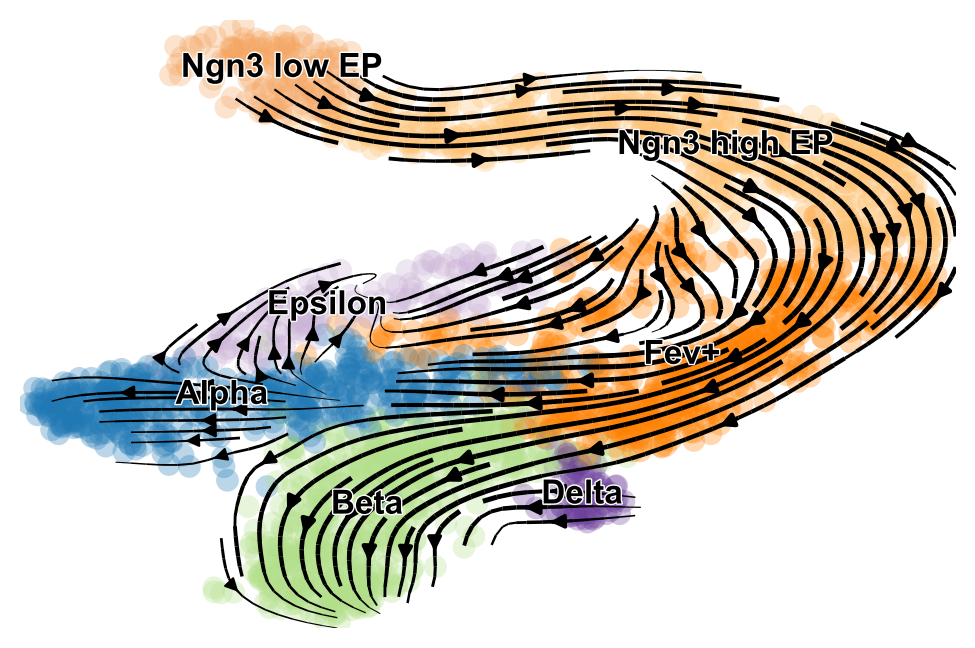

In [6]:
scv.pl.velocity_embedding_stream(adata, basis='umap', legend_fontsize=12, title='', smooth=.8, min_mass=4)

## Run CellRank

CellRank builds on the velocities computed by scVelo to compute root and final states of the dynamical process. It further uses the velocities to calculate how likely each cell is to develop towards each final state. Before we start, we recompute the velocity graph using `mode_neighbors='connectivities'`, which ensures that the resulting Markov chain is [irreducible](https://en.wikipedia.org/wiki/Markov_chain). 

In [7]:
scv.tl.velocity_graph(adata, mode_neighbors='connectivities')

computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


## Identify final states

Final states can be computed by running the following command:

In [8]:
cr.tl.final_states(adata, cluster_key='clusters')

Computing `final_states`
Computing transition matrix based on velocity correlations
    Finish (0:00:00)
Computing eigendecomposition of transition matrix
Computing metastable states
INFO: Using pre-computed schur decomposition
Adding `.schur_vectors`
       `.metastable_states`
       `.coarse_T`
       `.coarse_stationary_distribution`
    Finish (0:00:00)
Adding `.lineage_probabilities
       `.diff_potential`


The most important parameters in the above function are:

 - `estimator`: this determines what's going to behind the scenes to compute the final states. Options are `cr.tools.CFLARE` ("Clustering and Filtering Left and Right Eigenvectors") or `cr.tl.GPCCA` ("[Generalized Perron Cluster Cluster Analysis](https://pubs.acs.org/doi/10.1021/acs.jctc.8b00079)"). The latter is the default, it computes final states by coarse graining the velocity-derived Markov chain into a set of macrostates that represent the slow-time scale dynamics of the process, i.e. it finds the states that you are unlikely to leave again, once you have entered them. 
 - `cluster_key`: takes a key from `adata.obs` to retrieve pre-computed cluster labels, i.e. 'clusters' or 'louvain'. These labels are then mapped to the set of final states, to associate a name and a color with each state.
 - `n_states`: number of expected final states. This parameter is optional - if it's not provided, this number is estimated from the so-called 'eigengap heuristic' of the spectrum of the transition matrix. 
 - `method`: This is only relevant for the estimator `GPCCA`. It determines the way in which we compute and sort the [real schur decomposition](https://en.wikipedia.org/wiki/Schur_decomposition). The default, `krylov`, is an iterative procedure that works with sparse matrices which allows the method to scale to very large cell numbers. It relies on the libraries [SLEPSc](https://slepc.upv.es/) and [PETSc](https://www.mcs.anl.gov/petsc/), which you will have to install separately, see our [installation instructions](https://cellrank.readthedocs.io/en/latest/installation.html). If your dataset is small (<5k cells), and you don't want to install these at the moment, use `method='brandts'`. The results will be the same, the difference is that `brandts` works with dense matrices and won't scale to very large cells numbers.   

When running the above command, CellRank adds a key `final_states` to adata.obs. This can be plotted conveniently using scVelo's scatter function:

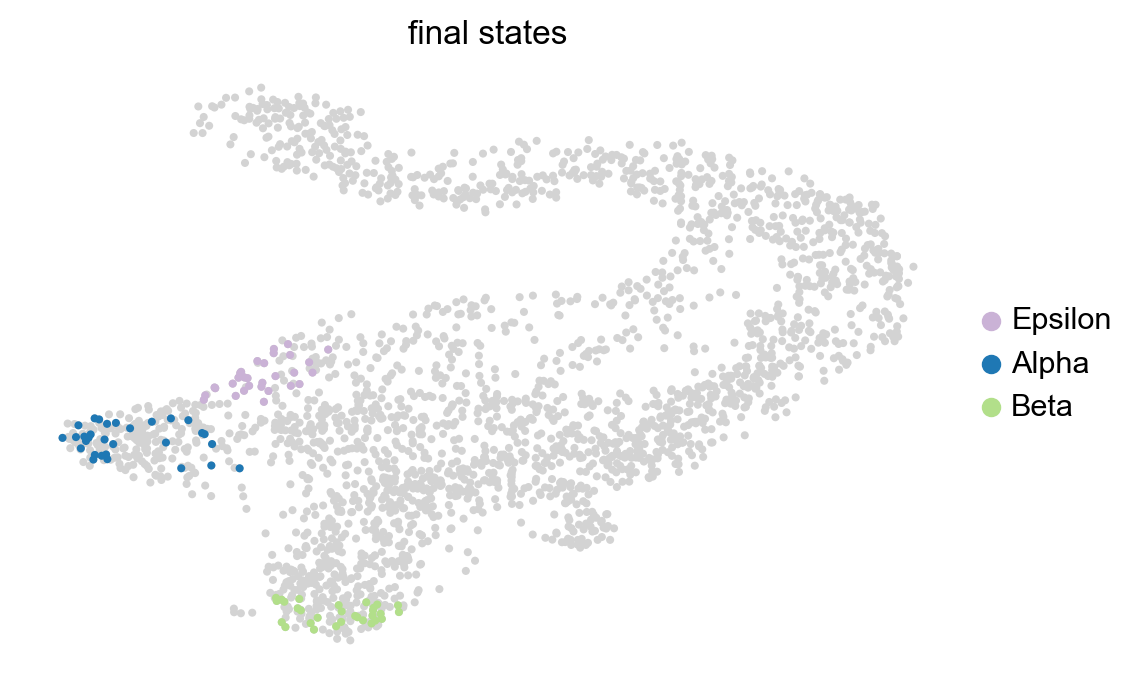

In [9]:
scv.pl.scatter(adata, color='final_states', legend_loc='right margin')

## Identify root states

The same sort of analysis can now be repeated for the root states, only that we use the function `cr.tl.root_states` this time:

Computing `root_states`
Computing transition matrix based on velocity correlations
    Finish (0:00:00)
Computing eigendecomposition of transition matrix
Computing metastable states
Computing eigendecomposition of transition matrix
Adding `.metastable_states`
    Finish (0:00:00)
Adding `.lineage_probabilities
       `.diff_potential`


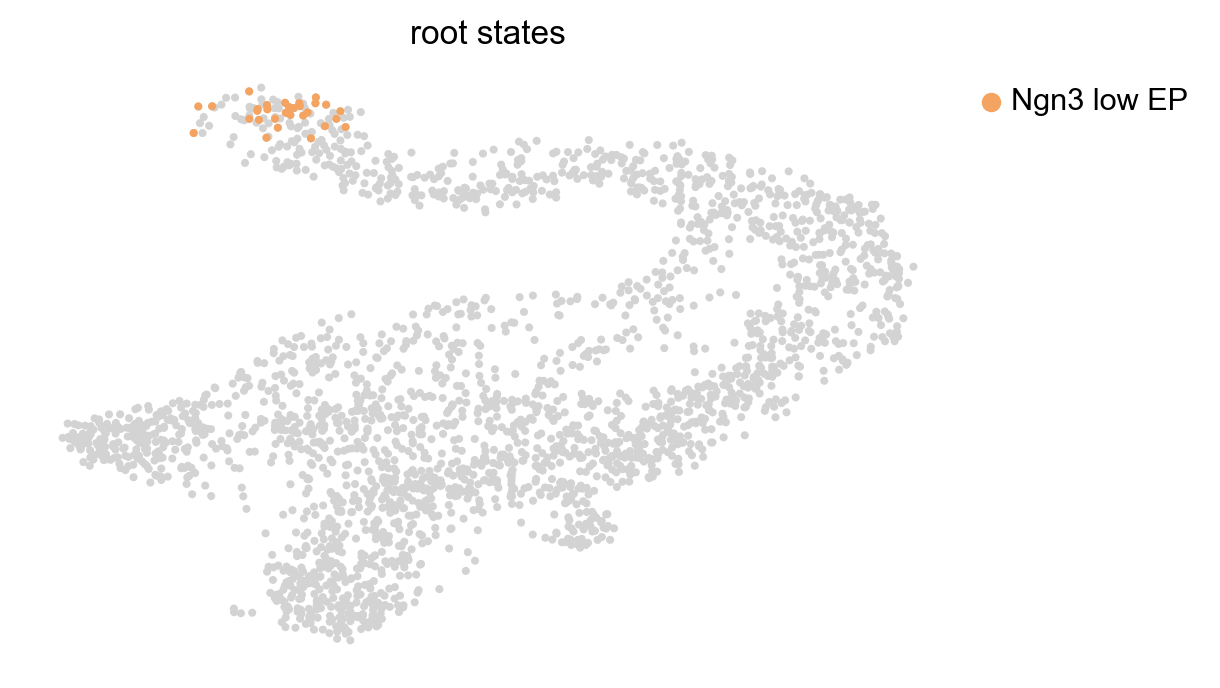

In [10]:
cr.tl.root_states(adata, cluster_key='clusters') 
scv.pl.scatter(adata, color='root_states')

We found one root state, located in the Ngn3 low EP cluster. 

## Compute fate maps

Once we know the final states, we can compute associated fate maps - for each cell, we ask how likely it is to develop towards each of the identified final states. 

Computing lineage probabilities towards `final_states`
Computing eigendecomposition of transition matrix
Computing metastable states
INFO: Using pre-computed schur decomposition
Adding `.schur_vectors`
       `.metastable_states`
       `.coarse_T`
       `.coarse_stationary_distribution`
    Finish (0:00:00)
Adding `.lineage_probabilities
       `.diff_potential`
Added key `to_final_states` to `adata.obsm`
    Finish (0:00:00)


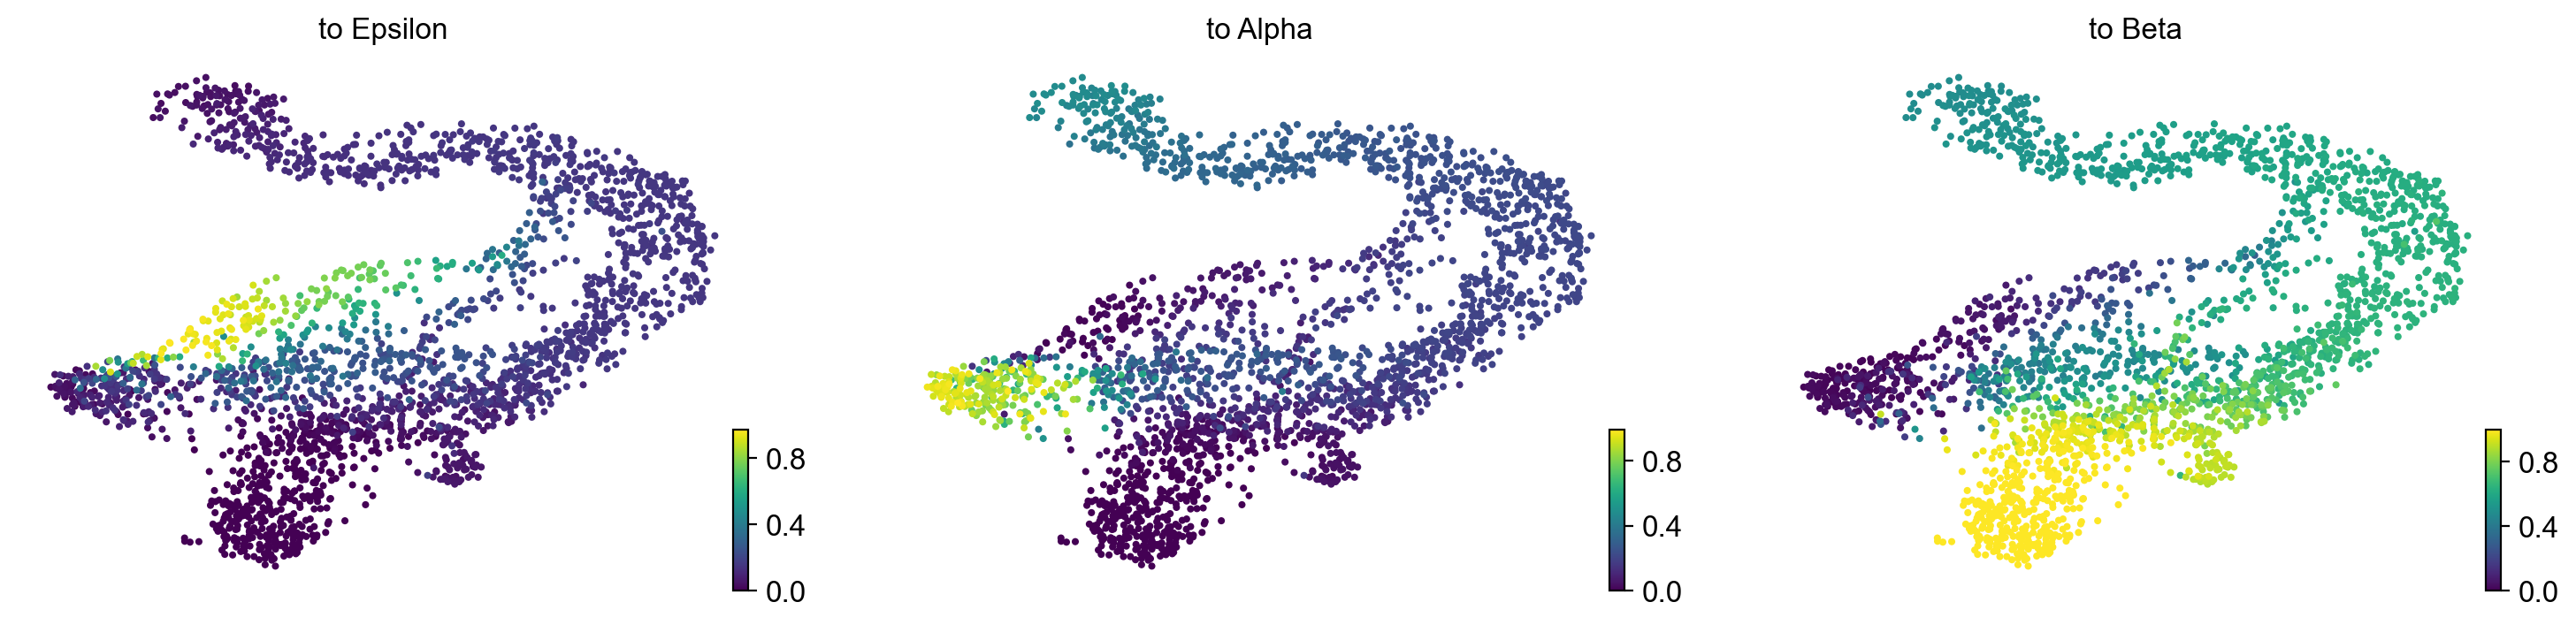

In [11]:
cr.tl.lineages(adata, cluster_key='clusters')
cr.pl.lineages(adata)

We can aggregate the above into a single, global fate map where we associate each final state with a color and use the intensity of that color to show the fate of each individual cell:

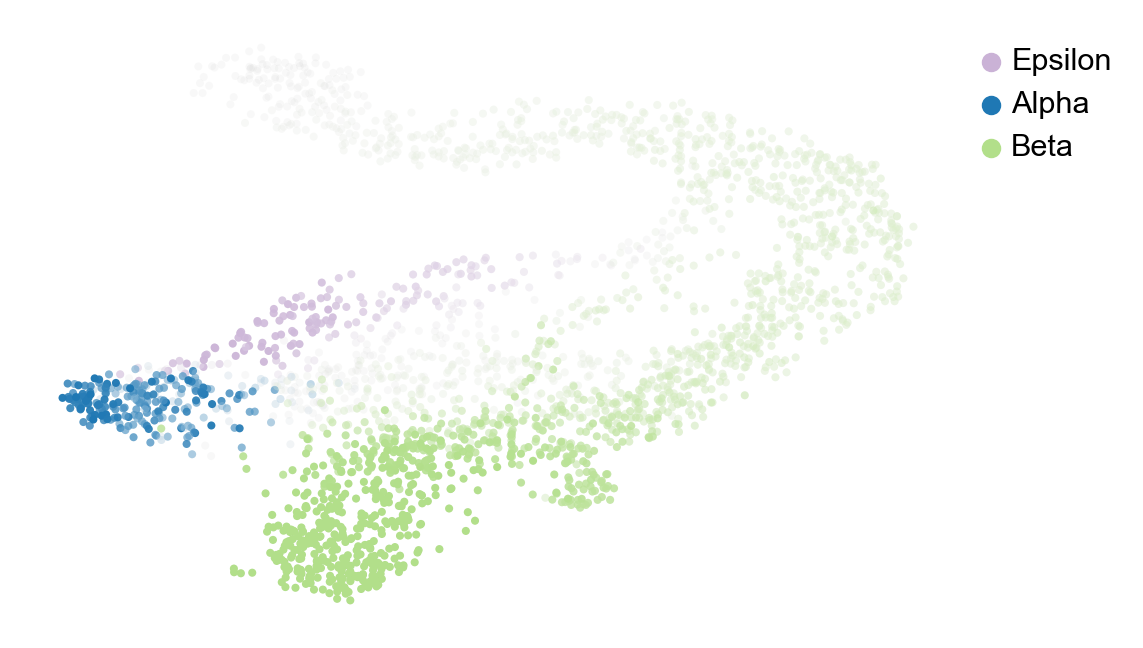

In [12]:
scv.pl.scatter(adata, color='final_states', color_gradients='to_final_states')

This shows that the dominant final state at E15.5 is beta, consistent with known biology, see e.g. [Bastidas-Ponce et al. (2018)](https://dev.biologists.org/content/146/12/dev173849.abstract). We can further aggragate the individual fate maps into a cluster-level fate map using an adapted version of [PAGA](https://scanpy.readthedocs.io/en/latest/api/scanpy.tl.paga.html#scanpy.tl.paga): 

running PAGA
    finished (0:00:00)


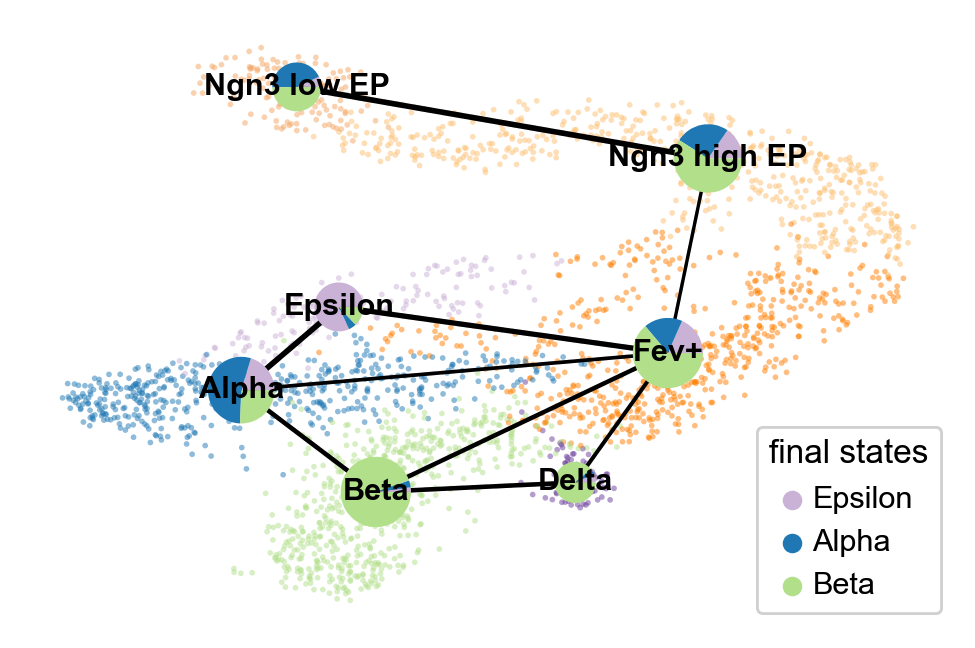

In [13]:
sc.tl.paga(adata, groups='clusters')
cr.pl.cluster_fates(adata, cluster_key='clusters', mode='paga_pie', node_size_scale=4,
                    title='', edge_width_scale=1, max_edge_width=2, threshold=0.1, basis='umap')

We use pie charts to show cell fates averaged per cluster. Edges between clusters are given by transcriptomoc similarity between the clusters, just as in normal [PAGA](https://scanpy.readthedocs.io/en/latest/api/scanpy.tl.paga.html#scanpy.tl.paga). 


Given the fate maps/probabilistic trajectories, we can ask interesting questions like:

- How similar are clusters in terms of their final cell probabilities ([cellrank.pl.similarity_plot](https://cellrank.readthedocs.io/en/latest/api/pl/cellrank.pl.similarity_plot.html#cellrank.pl.similarity_plot))?
- How does expression of a given gene vary along a specified lineage/trajectory ([cellrank.pl.gene_trends](https://cellrank.readthedocs.io/en/latest/api/pl/cellrank.pl.gene_trends.html#cellrank.pl.gene_trends) and [cellrank.pl.heatmap](https://cellrank.readthedocs.io/en/latest/api/pl/cellrank.pl.heatmap.html#cellrank.pl.heatmap))?
- How plastic are different cellular subpopulations ([cellrank.pl.cluster_fates(adata, ..., mode='violin')](https://cellrank.readthedocs.io/en/latest/api/pl/cellrank.pl.cluster_fates.html#cellrank.pl.cluster_fates)?

To find out more, check out the CellRank [API](https://cellrank.readthedocs.io/en/latest/api.html). 

## Plot smooth gene expression trends along trajectories

The functions demonstrated above are the main functions of CellRank: computing root and final states and probabilistic fate maps. We can use the computed probabilites now e.g. to smooth gene expression trends along lineages. 

Let's start with a temporal ordering for the cells. To get this, we can compute scVelo's [latent time](https://scvelo.readthedocs.io/scvelo.tl.latent_time.html#scvelo.tl.latent_time), starting from the CellRank-computed root's by specifying the `root_key` and `end_key` parameters. Alternatively, we can just use CellRank's root states to compte a [Diffusion Pseudotime](https://doi.org/10.1038/nmeth.3971). 

computing latent time using root_states_probs, final_states_probs as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99748987 0.9902442  0.9816529  0.9754233  0.96905994
     0.9629265  0.956972   0.940595   0.92121476 0.9155121  0.89869034
     0.89076036 0.88460636 0.8736001 ]
    finished (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)


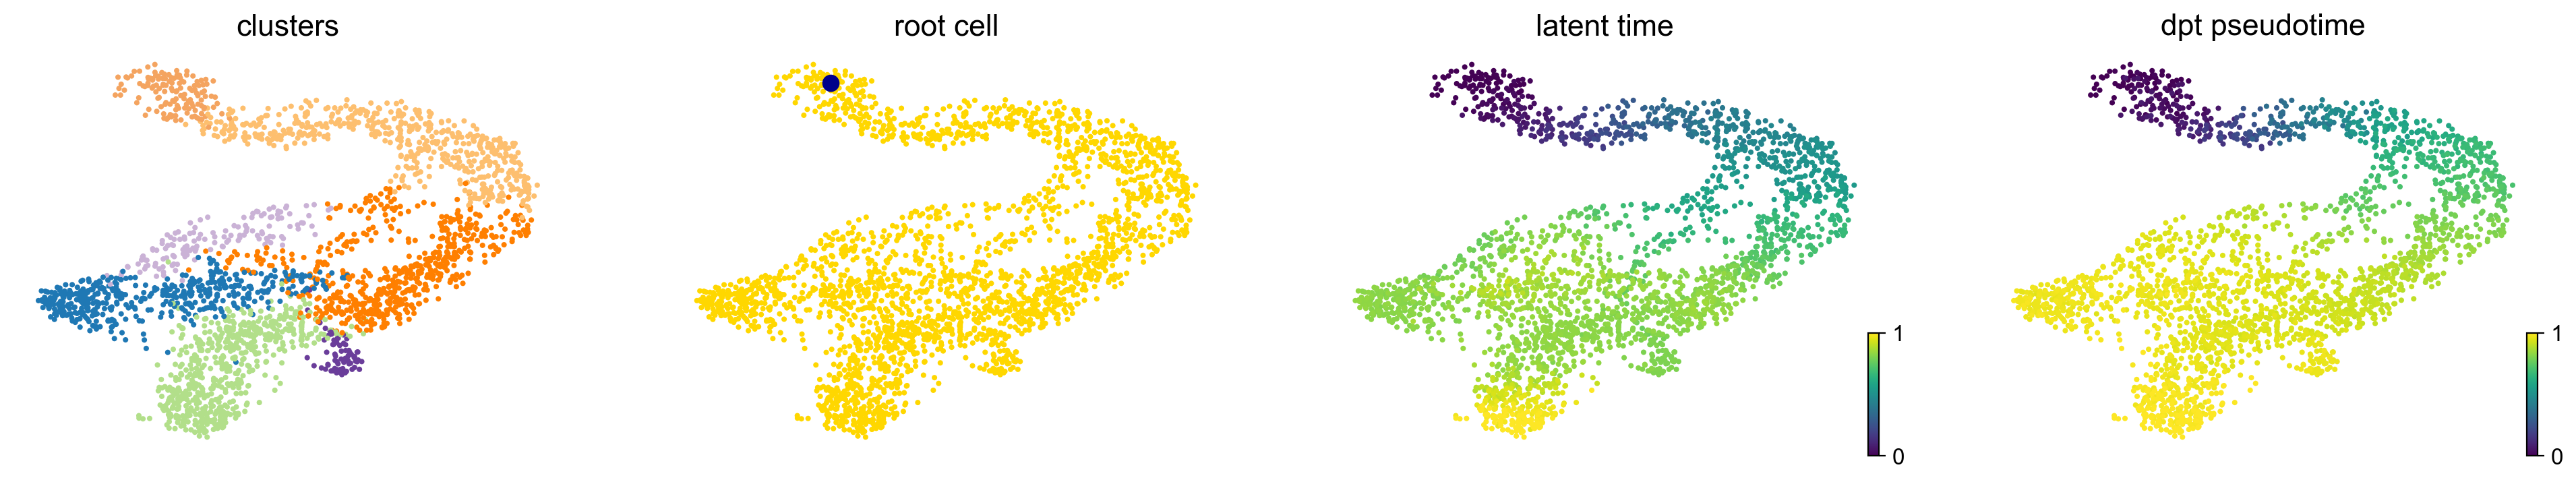

In [14]:
# compute latent time
scv.tl.recover_latent_time(adata, root_key='root_states_probs', end_key='final_states_probs')

# compue dpt, starting from cellrank defined root cell
root_idx = np.where(adata.obs['root_states'] == 'Ngn3 low EP')[0][0]
adata.uns['iroot'] = root_idx
sc.tl.dpt(adata)

scv.pl.scatter(adata, color=['clusters', root_idx, 'latent_time', 'dpt_pseudotime'], fontsize=16, cmap=cm.viridis, perc=[2, 98], colorbar=True, rescale_color=[0, 1], 
              title=['clusters', 'root cell', 'latent time', 'dpt pseudotime'])

We can plot dynamics of genes in pseudotime along individual trajectories, defined via the fate maps we computed above. `model` can be any `scikit-learn` model. 

Computing trends using `1` core(s)



    Finish (0:00:04)


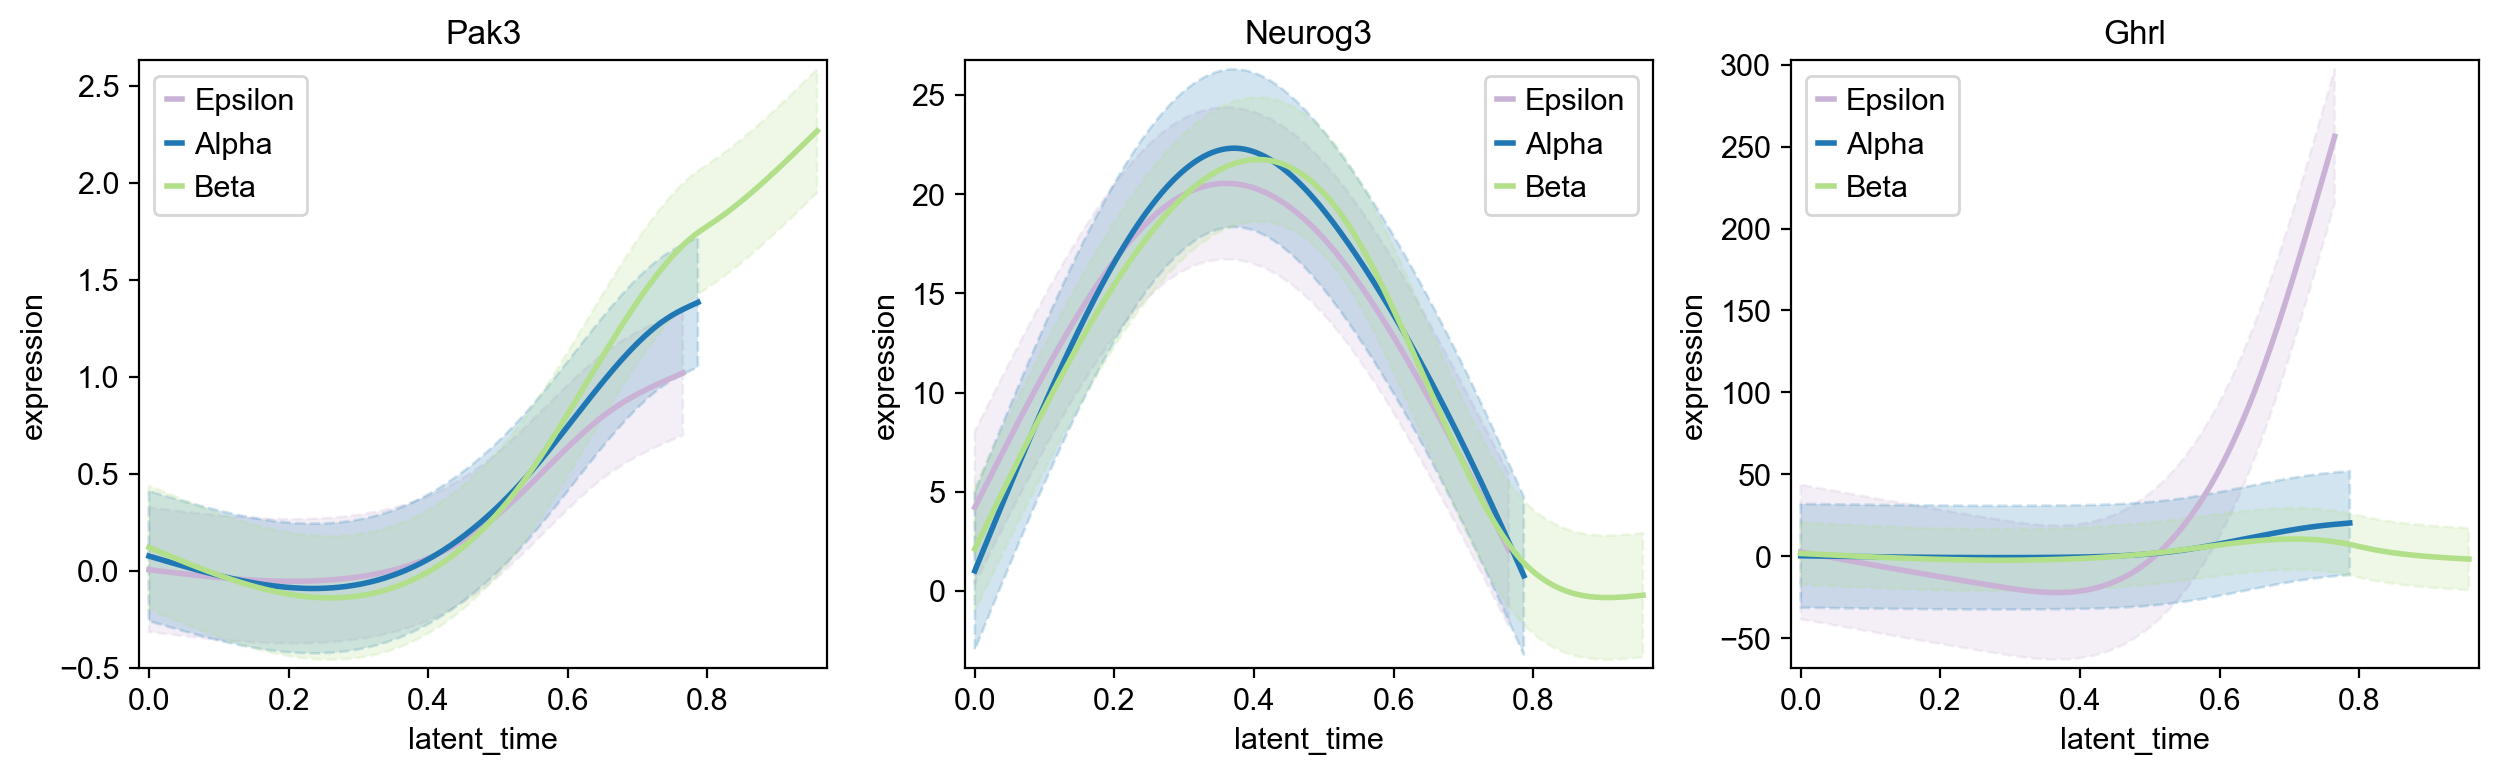

In [15]:
model = cr.ul.models.GamMGCVModel(adata, n_splines=5, sp=100)  # requires R's 'mgcv' package
cr.pl.gene_trends(adata, model=model, data_key='Ms',
                  genes=['Pak3','Neurog3', 'Ghrl'], ncols=3,
                  time_key='latent_time', same_plot=True, hide_cells=True, filter_data=True,
                  weight_threshold=0.05, weight_scale=1, figsize=(15, 4), n_test_points=300)

Gene expression trends can equally be visualized as heatmaps, see `cellrank.pl.heatmap`. 